In [3]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from datetime import datetime
import pandas as pd
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import pyecharts
from pyecharts.chart import Chart
from pyecharts import Bar
#from pyecharts import options as opts
from pyecharts import Kline as kline

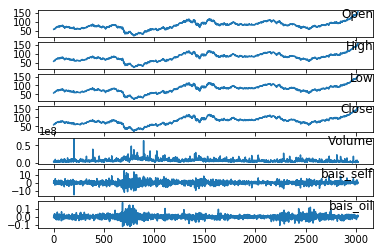

In [4]:
#plot各因素折线图
dataset = read_csv('CAT_2006-01-01_to_2018-01-01.csv ', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5,6]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [514]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [515]:
#数据加载
# load dataset
dataset = read_csv('CAT_2006-01-01_to_2018-01-01.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')

# 将数据归一化到0-1之间,无量纲化
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values)

# 将时序数据转换为监督问题数据
reframed = series_to_supervised(scaled_data, 1, 1)
#删除无用的label数据
reframed.drop(reframed.columns[[7,8,9,11,12,13]], axis=1, inplace=True)#9为var4t
print(reframed.head())
#Open High Low Close Volume Bias

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.260118   0.257240   0.260236   0.261505   0.052048   0.496488   
2   0.260709   0.266992   0.263918   0.272294   0.065056   0.583465   
3   0.268611   0.270168   0.274595   0.272294   0.065255   0.496488   
4   0.271935   0.276817   0.277393   0.280954   0.081544   0.564575   
5   0.279173   0.283614   0.285273   0.289028   0.062573   0.558720   

   var7(t-1)   var4(t)  
1   0.402941  0.272294  
2   0.418852  0.272294  
3   0.371269  0.280954  
4   0.477548  0.289028  
5   0.369057  0.287193  


In [516]:
#训练天数划分
train_days = 1812
valid_days = 604
values = reframed.values
train = values[:train_days, :]
valid = values[train_days:train_days+valid_days, :]
test = values[train_days+valid_days:, :]


train_X, train_y = train[:, :-1], train[:, -1]
valid_X, valid_y = valid[:, :-1], valid[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# 将数据集重构为符合LSTM要求的数据格式,即 [样本，时间步，特征]
#训练
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1])) 
#验证
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
#测试
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(1812, 1, 7) (1812,) (604, 1, 7) (604,) (601, 1, 7) (601,)


In [517]:
print(train_X.shape[1], train_X.shape[2])

1 7


Train on 1812 samples, validate on 604 samples
Epoch 1/100
 - 2s - loss: 0.0416 - val_loss: 0.0010
Epoch 2/100
 - 0s - loss: 0.0093 - val_loss: 6.3919e-04
Epoch 3/100
 - 0s - loss: 0.0057 - val_loss: 6.4553e-04
Epoch 4/100
 - 0s - loss: 0.0036 - val_loss: 8.1299e-04
Epoch 5/100
 - 0s - loss: 0.0021 - val_loss: 8.2741e-04
Epoch 6/100
 - 0s - loss: 0.0012 - val_loss: 6.6045e-04
Epoch 7/100
 - 0s - loss: 6.8893e-04 - val_loss: 4.3952e-04
Epoch 8/100
 - 0s - loss: 4.1519e-04 - val_loss: 2.7069e-04
Epoch 9/100
 - 0s - loss: 2.8502e-04 - val_loss: 1.7390e-04
Epoch 10/100
 - 0s - loss: 2.2516e-04 - val_loss: 1.2648e-04
Epoch 11/100
 - 0s - loss: 1.9723e-04 - val_loss: 1.0506e-04
Epoch 12/100
 - 0s - loss: 1.8353e-04 - val_loss: 9.5780e-05
Epoch 13/100
 - 0s - loss: 1.7631e-04 - val_loss: 9.1846e-05
Epoch 14/100
 - 0s - loss: 1.7213e-04 - val_loss: 9.0146e-05
Epoch 15/100
 - 0s - loss: 1.6945e-04 - val_loss: 8.9335e-05
Epoch 16/100
 - 0s - loss: 1.6755e-04 - val_loss: 8.8860e-05
Epoch 17/100
 

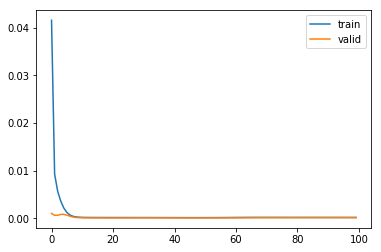

In [518]:
#模型
model = Sequential()
#50个神经元的LSTM和用于预测输出层中的1个神经元。输入形状是1个时间步长，具有6个特征。
model.add(LSTM(50,input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))    #50,1,6
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam') 
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(valid_X, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [519]:
#预测
train_predict = model.predict(train_X)
valid_predict = model.predict(valid_X)
test_predict = model.predict(test_X)

#X1=scaler.inverse_transform(train_predict)

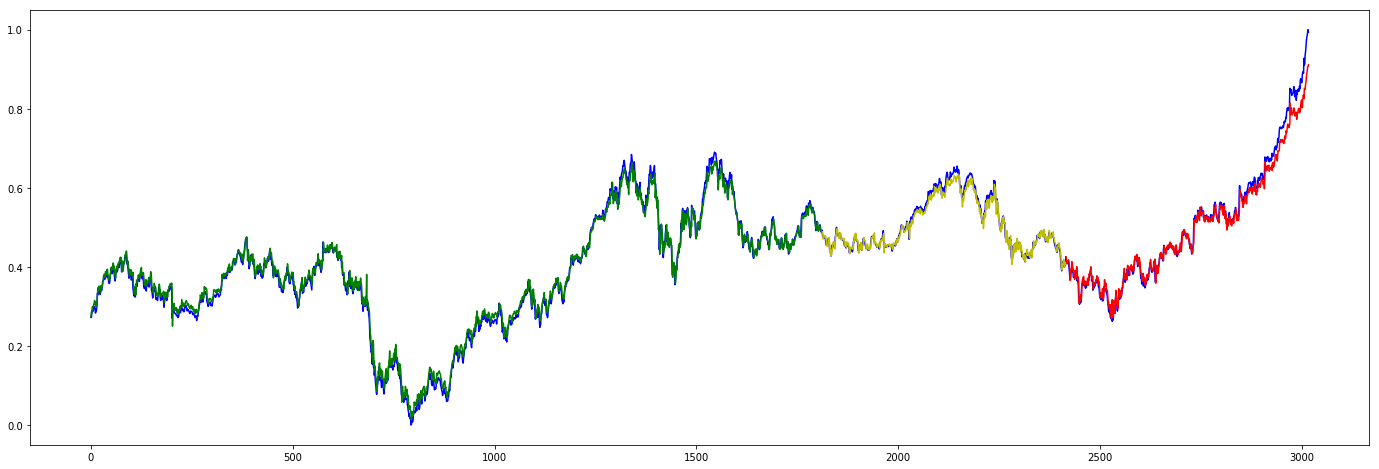

In [520]:
#绘图
plt.figure(figsize=(24,8))
plt.plot(values[:,-1], c='b')
plt.plot([x for x in train_predict], c='g')
plt.plot([None for _ in train_predict] + [x for x in valid_predict], c='y')
plt.plot([None for _ in train_predict] + [None for _ in valid_predict] + [x for x in test_predict], c='r')
plt.show()

In [521]:
a=train_predict.flatten()
b=valid_predict.flatten()
c=test_predict.flatten()

d=values[:,-1]
print(train_predict.shape)
print(len(d))

(1812, 1)
3017


In [522]:
#pychart绘图
tr=train_predict.tolist()
va=valid_predict.tolist()
te=test_predict.tolist()
al=d.tolist()

for i in range(0,(3017-len(train_predict.tolist()))):
    tr.append(np.nan)
print(len(tr))
for i in range(0,(len(train_predict.tolist()))):
    va.insert(i,np.nan)
print(len(va))
for i in range(0,(len(test_predict.tolist()))):
    va.append(np.nan)
print(len(va))

for i in range(0,len(train_predict.tolist())+len(valid_predict.tolist())):
    te.insert(i,np.nan)
print(len(te))



date=[]
for i in range(0,3017):
    date.append(i)
print(type(date))



line = pyecharts.Line('基于LSTM多特征的CAT股票走势分析','开盘、收盘、高低点、交易量、自身涨跌、原油涨跌因素',width=1980,height=1080)
line.add("训练集", date,tr, is_smooth=True,is_datazoom_show=True)
line.add("验证集", date,va, is_smooth=True)
line.add("测试集", date,te, is_smooth=True,mark_line=['max','min','average'])
line.add("原值", date,al, is_smooth=True,mark_line=['max','min','average'])
line.render('predict3.html')  

3017
2416
3017
3017
<class 'list'>


In [497]:
#Open High Low Close Volume Bias
dataset = read_csv('CAT_2006-01-01_to_2018-01-01sc.csv ', header=0, index_col=0)
values = dataset.values
from pyecharts import Scatter
v5 = dataset.values[:,5]#单日涨跌幅
v0 = dataset.values[:,0]#开盘价
v1 = dataset.values[:,1]#收盘价
v2 = dataset.values[:,2]#单日最低成交价
v3 = dataset.values[:,3]#单日最高成交价
v4 = dataset.values[:,4]#交易量
v6 = dataset.values[:,6]#CVX单日涨跌幅
v8 = dataset.values[:,8]#油价涨跌幅

sbsize=3
scatter = Scatter(u'单日涨跌幅因素分析',width=1600,height=900)
scatter.add(u'开盘价',v5,v0,symbol_size = sbsize)
scatter.add(u'收盘价',v5,v1,symbol_size = sbsize)
scatter.add(u'最低成交价',v5,v2,symbol_size = sbsize)
scatter.add(u'最高成交价',v5,v3,symbol_size = sbsize)
scatter.add(u'交易量',v5,v4,symbol_size = sbsize)
scatter.add(u'CVX单日涨跌幅',v5,v6,symbol_size = sbsize)
scatter.add(u'油价涨跌幅',v5,v8,symbol_size = sbsize, )

scatter.render('trade_bias.html')

In [498]:
#K线图
datasetk = read_csv('CAT_2006-01-01_to_2018-01-01k.csv ', header=0, index_col=0)
valuesk = datasetk.values
kdata=valuesk[:,0:4]
date=[]
for i in range(0,3020):
    date.append(i)
kline = Kline("CAT 单日K线图",width=1600,height=900)
kline.add("日K", date, kdata,is_datazoom_show=True,mark_line=['max','min','average'])#is_visualmap=True,
          #visual_range = [0,200],
          #visual_type = 'size'

kline.render('K线图.html')